In [2]:
from utilities.preprocessing import *
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import networkx as nx
import igraph as ig
# import numba
import itertools
from console_progressbar import ProgressBar
import re
from graph_tool.all import *
import graph_tool as gt
from math import *
import matplotlib
from scipy.stats import norm
import matplotlib.mlab as mlab
from colormap import rgb2hex
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
import scipy.stats as stats

%matplotlib inline

In [422]:
path = '../trending_yt_videos/'

'Import json'
with open(path + 'US_category_id.json') as f:
  videos = json.load(f)

'Save all the categories in dict[id]=category'
categories = {}
for cat in videos['items']:
    # print(cat)
    this_cat = cat['snippet']['title']
    id = cat['id']
    categories[id] = this_cat


In [423]:
len(categories.keys())

32

In [4]:
'Import video dataset:'

video_stats = pd.read_csv(path + 'USvideos.csv')
video_stats = video_stats.replace({'likes':0,'dislikes':0,'comment_count':0},np.nan)
video_stats.dropna(subset=['likes','dislikes','comment_count'],inplace=True)

# EDA

In [5]:
video_stats.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...


In [163]:
def generate_plot(ars,labs,cols,dx,dy,tdx,tdy,pnorm,plog,addline,title,save,name,xlab,ylab,displaytext,dec,style):
    '''
    Create plot with some useful customizations.
    Parameters:
        - ar1
        - ar2
        - 

    '''
    if not style:
        style = 'seaborn-paper'
    
    if not dec:
        dec = 4
        
    plt.style.use(style)

    fig = plt.figure()

    N = len(ars)

    if plog:
        for ar in range(N):
            ars[ar] = np.log10(ars[ar])

    x_axis = np.linspace(min([min(ar) for ar in ars]),max([max(ar) for ar in ars]))

    mus = []
    sigmas = []
    for ar in ars:
        (mu,sigma) = norm.fit(ar)
        mus.append(mu)
        sigmas.append(sigma)

    for i in range(N):
        ar = ars[i]
        col = cols[i]
        lab = labs[i]
        mu = mus[i]
        sigma = sigmas[i]

        plt.hist(ar,color = col,alpha=0.4,label=lab,density=pnorm)

        if pnorm:
            plt.plot(x_axis,norm.pdf(x_axis,mu,sigma), color = col)

        if addline:
            plt.vlines(mu,ymin=0,ymax=max(norm.pdf(x_axis,mu,sigma)),linestyles='dashed',color = col)
            pmu = int(10**mu) if int(10**mu) != 0 else np.around(10**mu,dec)
            plt.text(x = (1+dx)*mu,y = (1+dy)*max(norm.pdf(x_axis,mu,sigma)),s = '$\mu = ${}'.format(pmu),color=col)

    plt.title(title)
    plt.legend()
    plt.ylabel(ylab)
    plt.xlabel(xlab)

    if displaytext:
        if N > 1:
            textstr = ''.join((
                r'$mean(\frac{\mu_{d}}{\mu_{l}}) = $',
                '{}'.format(np.around(10**(mus[1]-mus[0]),4))
            ))

            props = dict(boxstyle = 'round',facecolor='wheat', alpha =0.5)

            plt.text(min(x_axis)*(1+tdx), max([max(norm.pdf(x_axis,mus[i],sigmas[i])) for i in range(N)])*(1+tdy), textstr,  fontsize=10,
                    verticalalignment='top', bbox=props)
                
    # plt.suptitle('Log10 distribution of likes & dislikes to views ratios')
    if save:
        plt.savefig('../images/'+name.split('.')[0]+'.pdf')

    # plt.show()



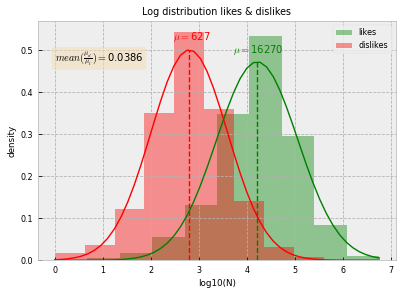

In [417]:
'''
Distribution likes & dislikes
'''



likes = video_stats.likes#[np.asarray(video_stats.likes != 0)]
dislikes = video_stats.dislikes#[np.asarray(video_stats.dislikes != 0)]

generate_plot(ars=[likes,dislikes],labs=['likes','dislikes'],cols=['green','red'],
            dx=-0.12,dy=0.05,tdx=-0.04,tdy=0,
            xlab='log10(N)',ylab='density',
            pnorm=True,plog=True,addline=True,
            title='Log distribution likes & dislikes',
            save=True,
            name='log_distribution_likes_dislikes',
            displaytext=True,
            dec=4,
            style='seaborn-paper')

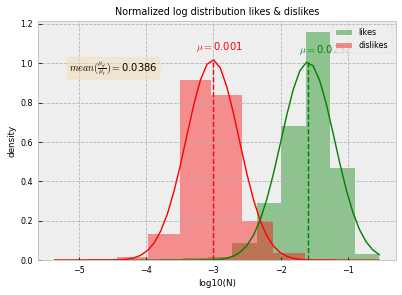

In [418]:
'''
Distribution normalized likes & dislikes
'''
views = video_stats.views[video_stats.views != 0]

generate_plot(ars=[likes/views,dislikes/views],labs=['likes','dislikes'],cols=['green','red'],
            dx=0.08,dy=0.05,tdx=-0.04,tdy=0,
            xlab='log10(N)',ylab='density',
            pnorm=True,plog=True,addline=True,
            title='Normalized log distribution likes & dislikes',
            save=True,
            name='normalized_logdistribution_likes_dislikes',
            displaytext=True,
            dec=4,
            style='seaborn-paper')


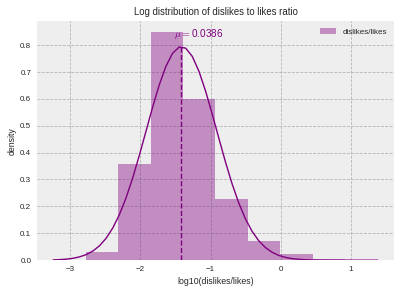

In [162]:
'''
Distribution likes/dislikes
'''
generate_plot(ars=[dislikes/likes],labs=['dislikes/likes'],cols=['purple'],
            dx=0.08,dy=0.05,tdx=-0.04,tdy=0,
            xlab='log10(dislikes/likes)',ylab='density',
            pnorm=True,plog=True,addline=True,
            title='Log distribution of dislikes to likes ratio',
            save=True,
            name='log_distribution_dislikes_over_likes',
            displaytext=True,
            style='seaborn-paper')



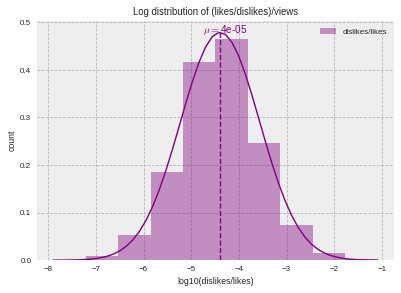

In [167]:
generate_plot(ars=[(likes/dislikes)/views],labs=['dislikes/likes'],cols=['purple'],
            dx=0.08,dy=-0,tdx=-0.04,tdy=0,
            xlab='log10(dislikes/likes)',ylab='count',
            pnorm=True,plog=True,addline=True,
            title='Log distribution of (likes/dislikes)/views',
            save=True,
            name='log_distribution_likes_over_dislikes_over_views',
            displaytext=True,
            dec=6,
            style='seaborn-paper')


In [168]:
set(video_stats.category_id)

{1, 2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 43}

In [169]:
new_col = [categories[f'{id}'] for id in video_stats.category_id]
video_stats['category'] = new_col

In [171]:
video_stats.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,12703.0,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,8181.0,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172.0,666.0,2146.0,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235.0,1989.0,17518.0,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment


In [173]:

video_stats['VLratio'] = video_stats.views/video_stats.likes
video_stats['VDratio'] = video_stats.views/video_stats.dislikes
video_stats['LDratio'] = video_stats.likes/video_stats.dislikes
video_stats['VCratio'] = video_stats.views/video_stats.comment_count

video_stats['log10VLratio'] = video_stats.VLratio.apply(np.log10)
video_stats['log10VDratio'] = video_stats.VDratio.apply(np.log10)
video_stats['log10LDratio'] = video_stats.LDratio.apply(np.log10)
video_stats['log10VCratio'] = video_stats.VCratio.apply(np.log10)

In [174]:
# video_stats.to_csv('../data/video_stats.csv',index=False)

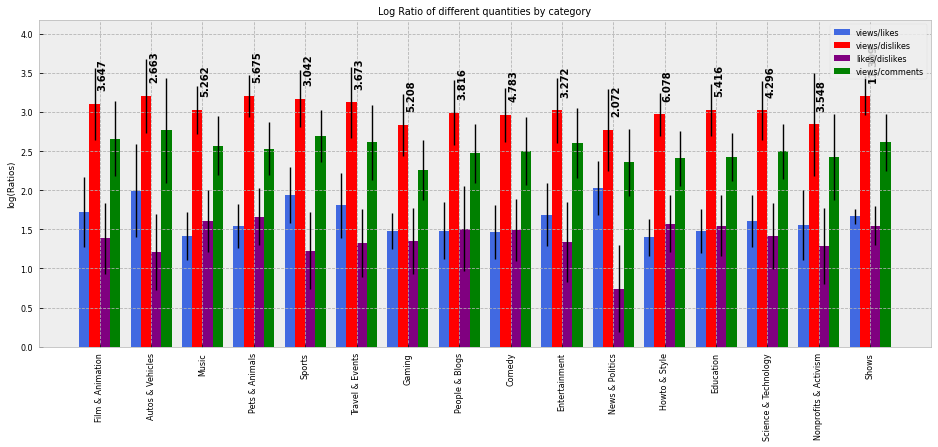

In [427]:
'''
Interesting metrics per category
'''
plt.style.use('seaborn-paper')

catmeans = video_stats.groupby('category_id').mean()
catstds = video_stats.groupby('category_id').std()

# likeMeans = catmeans.LVratio
# likeStd =   catstds.LVratio

likeMeans = catmeans.log10VLratio
likeStd =   catstds.log10VLratio

N = len(likeMeans)
ind = np.arange(N)  # the x locations for the groups
width = 0.20      # the width of the bars

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, likeMeans, width, color='royalblue', yerr=likeStd,ecolor='black')

dislikeMeans = catmeans.log10VDratio
dislikeStd =   catstds.log10VDratio
# dislikeMeans = np.log10(catmeans.DVratio)
# dislikeStd =   np.log10(catstds.DVratio)

rects2 = ax.bar(ind+width, dislikeMeans, width, color='red', yerr= dislikeStd,ecolor='black')

LDMeans = catmeans.log10LDratio
LDStd =   catstds.log10LDratio
# DLMeans = np.log10(catmeans.DLratio)
# DLStd =   np.log10(catstds.DLratio)

rects3 = ax.bar(ind+width*2, LDMeans, width, color='purple', yerr= LDStd,ecolor='black')

VCMeans = catmeans.log10VCratio
VCStd = catstds.log10VCratio

rects4 = ax.bar(ind+width*3, VCMeans, width, color='green', yerr= VCStd,ecolor='black')


ax.set_ylabel('log(Ratios)')
ax.set_title('Log Ratio of different quantities by category')
ax.set_xticks(ind + width*1.5 )
ax.set_xticklabels( [categories[f'{id}'] for id in list(catmeans.index)]) 
ax.set_ylim(0,max(dislikeMeans)*(1+0.3))
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), 
            ('views/likes', 'views/dislikes','likes/dislikes','views/comments'),
            loc = 'upper right')

def compute_scores(likeMeans,likeStd,dislikeMeans,dislikeStd,LDMeans,LDStd):
    return 1/likeMeans * 1/likeStd - 1/dislikeMeans * 1/dislikeStd + LDMeans/LDStd

scores = compute_scores(likeMeans,likeStd,dislikeMeans,dislikeStd,LDMeans,LDStd)
for px,score in enumerate(scores):
    ax.text(x=px + width*1.3,y = dislikeMeans.values[px] + width,s='{}'.format(np.around(score,3)),fontweight='bold',rotation=90)

plt.xticks(rotation=90)



plt.show()
fig.savefig('../images/log_ratio_categories.pdf')

In [328]:
np.std([1,1000,100000])

46906.2871905249

In [327]:
video_stats.groupby('category').delta_t.std()


category
Autos & Vehicles         8.474420e+06
Comedy                   5.728781e+06
Education                2.177887e+07
Entertainment            9.057841e+06
Film & Animation         2.312042e+07
Gaming                   9.476075e+06
Howto & Style            2.350171e+06
Music                    1.243408e+07
News & Politics          1.437904e+07
Nonprofits & Activism    2.636077e+05
People & Blogs           9.663365e+06
Pets & Animals           4.245122e+05
Science & Technology     1.177536e+07
Shows                    5.956398e+05
Sports                   9.628944e+06
Travel & Events          3.618298e+05
Name: delta_t, dtype: float64

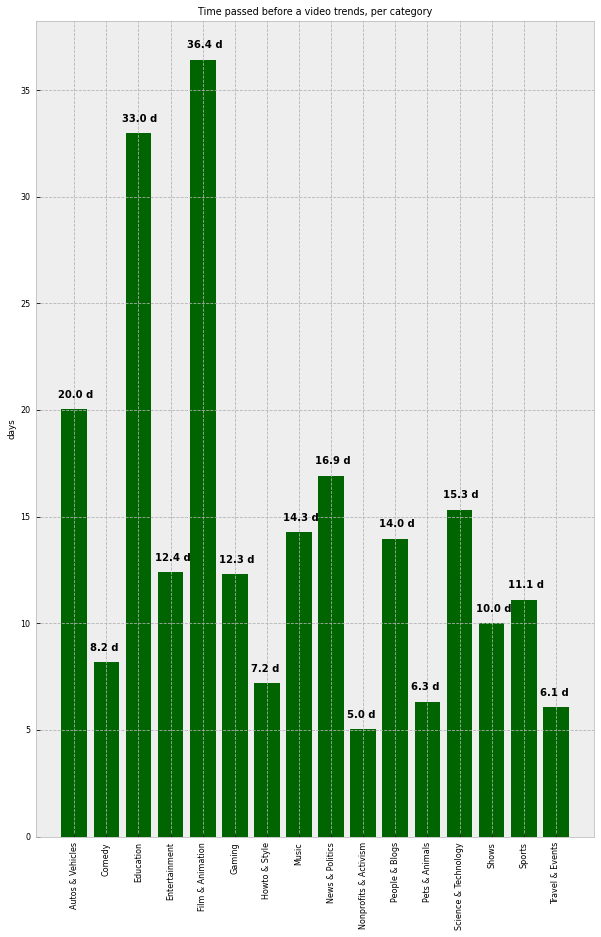

In [415]:
'''
Delta-Time publish date and trending date
'''
import datetime as dt 

# video_stats['delta_t'] = [(dt.datetime.strptime(video_stats.trending_date.values[i],'%y.%d.%m') - dt.datetime.strptime(' '.join(video_stats.publish_time.values[i].split('Z')[0][:-4].split('T')),'%Y-%m-%d %H:%M:%S')).total_seconds() for i in range(len(video_stats))]
# video_stats.to_csv('../data/video_stats.csv',index=False)
fig = plt.figure(figsize=(10,15))
plt.style.use('seaborn-paper')
plt.bar(x=video_stats.groupby('category').delta_t.mean().index,height=video_stats.groupby('category').delta_t.mean().values/(3600*24),color = 'darkgreen')
plt.xticks(rotation=90)
for i,delta in enumerate(video_stats.groupby('category').delta_t.mean().values/(3600*24)):
    plt.text(x=i - 0.5,y=delta,s = f'{np.around(delta,1)} d \n',fontweight='bold')

plt.ylabel('days')
plt.title('Time passed before a video trends, per category')
plt.show()
fig.savefig('../images/delta_t.pdf')

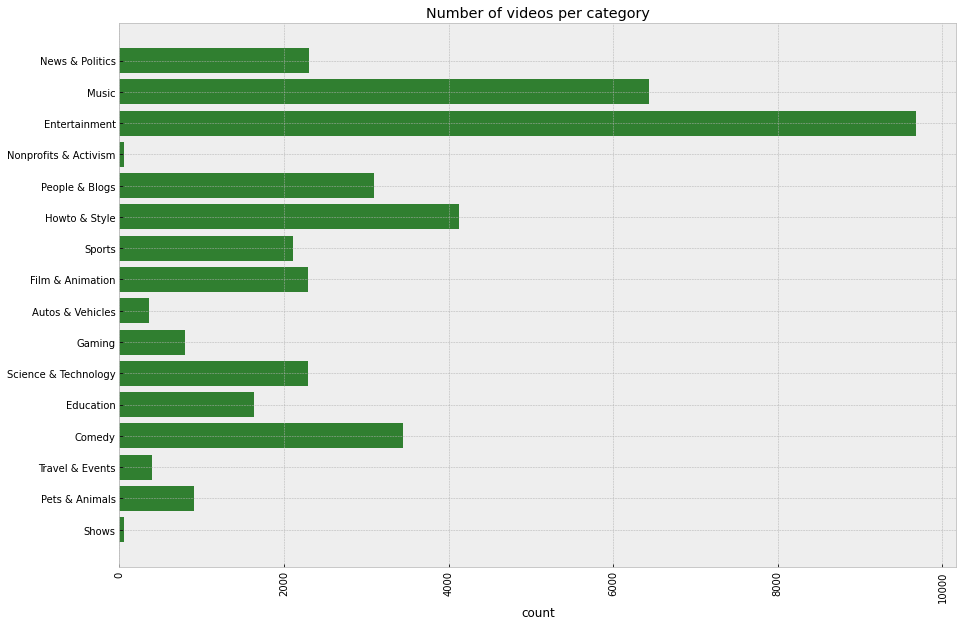

In [413]:
'''
Number of videos per category (US)
'''
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
plt.barh(y = list(set(video_stats.category.values)),width=[len(video_stats[video_stats.category == cat]) for cat in list(set(video_stats.category.values))],color='darkgreen',alpha=0.8)
# video_stats.groupby('category').count().plot.bar(legend=False,color='green')
plt.xticks(rotation=90)
plt.title('Number of videos per category')
plt.xlabel('count')
plt.show()
fig.savefig('../images/nvideos_per_category.pdf')

In [409]:
len(video_stats.category.values)

40003

# Creating the graph from the video dataset

In [428]:
video_stats.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,category,VLratio,VDratio,LDratio,VCratio,log10VLratio,log10VDratio,log10LDratio,log10VCratio,delta_t
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527.0,2966.0,...,People & Blogs,13.009091,252.317599,19.395482,46.908236,1.114247,2.401948,1.287701,1.671249,24419.0
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185.0,6146.0,...,Entertainment,24.888440,393.554019,15.812724,190.410376,1.395998,2.595004,1.199007,2.279691,59400.0
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033.0,5339.0,...,Comedy,21.854197,597.758756,27.352126,390.103166,1.339535,2.776526,1.436991,2.591179,104076.0
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172.0,666.0,...,Entertainment,33.736532,515.267267,15.273273,159.910531,1.528100,2.712033,1.183932,2.203877,46796.0
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235.0,1989.0,...,Entertainment,15.848535,1053.660633,66.483157,119.633006,1.199989,3.022701,1.822712,2.077851,107899.0


In [7]:

# @numba.njit
def build_edgesnodes(videos,save=False,path=None):
    '''
    ----------------------------------------------------------------------------------------
    Takes a dataframe and returns the list of nodes and edges, and the dictionary mapping 
    for each tag the corresponding category
    Parameters:
        - videos: dataframe
        - save: if True saves to "path"
        - path: string
    ----------------------------------------------------------------------------------------
    '''
    
    pb = ProgressBar(total=100,prefix='Done:', suffix='Now', decimals=0, length=50, fill='#', zfill='-')

    list_of_tags = [videos.channel_title.values[idx] + '|' + videos.tags.values[idx] for idx in range(len(videos))]
    list_of_tags = [re.sub("\"","",tag).split('|') for tag in list_of_tags]

    len_graph = []
    for vg in list_of_tags:
        len_graph.extend(vg)    

    if save and not path:
        raise ValueError('Please insert a valid path in which to save the nodes and edges!')
    elif save and path:
        if not os.path.exists(path):
            os.makedirs(path)
    
    nodes = {node:k for k,node in enumerate(list(set(len_graph)))}
    
    # print(list_of_tags)
    tagcategories = {}
    for row,tags in enumerate(list_of_tags):
        for tag in tags:
            cat_id = str(videos.iloc[row].category_id)
            if tag not in tagcategories:
                # tag_categories[tag] = [str(int(videos.iloc[row].category_id))]
                tagcategories[tag] = [categories[cat_id]]
            elif tag in tagcategories and categories[cat_id] not in tagcategories[tag]:
                # tag_categories[tag].append(str(int(videos.iloc[row].category_id)))
                tagcategories[tag].append(categories[cat_id])
        

    len_graph = len(set(len_graph))


    edges = []


    for counter,tags in enumerate(list_of_tags):
        progress = int((counter+1)/len(list_of_tags) * 100)
        pb.print_progress_bar(progress)     
        edges.extend(list(itertools.combinations(tags,2)))
        edges = list(set(edges))
    
    if save:
        '''
        Save nodes:
        '''
        nodes_df = pd.DataFrame(nodes.keys())
        nodes_df['Id'] = nodes.values()
        nodes_df.columns = ['Label','Id']
        nodes_df['Category'] = [tag_categories[tag] for tag in nodes_df.Label.values]
        nodes_df.drop(nodes_df.index[0],inplace=True)
        nodes_df = nodes_df.reindex(columns = ['Id','Label','Category'])
        nodes_df.drop(nodes_df[nodes_df.Id == 0].index, inplace = True)
        pd.DataFrame(nodes_df).to_csv('nodes.csv',index=False)

        '''
        Save edges:
        '''
        edges_df = pd.DataFrame([source[0] for source in edges])
        edges_df.columns = ['From']
        edges_df['To'] = [source[1] for source in edges]
        edges_df['Source'] = [nodes[source[0]] for source in edges]
        edges_df['Target'] = [nodes[source[1]] for source in edges]
        edges_df = edges_df.reindex(columns = ['Source','Target','From','To'])

        edges_df.drop(edges_df[edges_df.Target == 0].index, inplace = True)
        edges_df.drop(edges_df[edges_df.Source == 0].index, inplace = True)

        'Save nodes to nodes.csv'
        edges_df.to_csv('edges.csv',index=False)
        

    return nodes,edges,tagcategories

In [38]:
%%time
'''
Build nodes and edges (takes ~4h to run)
'''

# nodes,edges,tag_categories = build_edgesnodes(video_stats,save=False,path=None) #build_edgesnodes(video_stats.iloc[:1000])

Done: |##################################################| 100% Now
CPU times: user 3h 41min 35s, sys: 16min 14s, total: 3h 57min 49s
Wall time: 3h 56min 56s


In [25]:
'''
Load edges and tones:
'''
nodes = pd.read_csv('../data/nodes.csv')
edges = pd.read_csv('../data/edges.csv')

In [373]:
edges.head()

,Source,Target,From,To
0,37930,16574,interesting finds,swimming
1,49908,19127,snl,SZA
2,23644,45851,JimBrowski 96HourNews,KELLYANNE CONWAY THIS WEEK ABC 11/12/17
3,26432,9336,black hole,universe
4,35938,47924,jewelry bling,gq jewelry tour


In [5]:
# g_test = nx.froms_dict_of_lists(dict_edges)
# g_test = nx.from_edgelist([(edges.From.values[i],edges.To.values[i]) for i in range(len(edges))])
# plt.plot(np.log(nx.degree_histogram(g_test)))
# plt.show()
# print(f'Assortativity coefficient: {nx.degree_assortativity_coefficient(g_test)}')


In [374]:
categories = {nodes.Label.values[i]:nodes.Category.values[i] for i in range(len(nodes))}

In [375]:
'''
Build graph:
'''
def build_graph(nodes,edges,categories):
    g = gt.Graph()
    v_cat = g.new_vertex_property("string")
    v_lab = g.new_vertex_property("string")


    for j in range(0, len(nodes)):
        v = g.add_vertex()
        v_lab[v] = nodes.Label.values[j]
        v_cat[v] = categories[nodes.Label.values[j]]

    for i in range(0,len(edges)):
        v1 = edges.Source.values[i]
        v2 = edges.Target.values[i]

        # if v1 not in list(v_lab):
        #     v = g.add_vertex()
        #     v_lab[v] = nodes.Label.values[v1]
        #     v_cat[v] = categories[nodes.Label.values[v1]]
        
        # if v2 not in list(v_lab):
        #     v = g.add_vertex()
        #     v_lab[v] = nodes.Label.values[v2]
        #     v_cat[v] = categories[nodes.Label.values[v2]]
        
        e = g.add_edge(v1,v2)
    return graph

# g = build_graph(nodes,edges,categories)

In [26]:
edges

,Source,Target,From,To
0,37930,16574,interesting finds,swimming
1,49908,19127,snl,SZA
2,23644,45851,JimBrowski 96HourNews,KELLYANNE CONWAY THIS WEEK ABC 11/12/17
3,26432,9336,black hole,universe
4,35938,47924,jewelry bling,gq jewelry tour
...,...,...,...,...
1354574,27601,26304,Lisa Eldridge,lip
1354575,8184,30689,top,best nfl plays
1354576,41862,36346,saints,bryant
1354577,991,7338,strawberry oasis pie,ham and cheese quiche recipe


In [28]:
'''
Load graph:
'''
g = gt.load_graph('../data/graph.gt')
gnx = nx.graph.Graph([(edges.Source.values[i],edges.Target.values[i]) for i in range(len(edges))])

## Network statistics: in-degree distribution, powerlaw and gamma estimation

In [ ]:
'''
In-Degree distribution
'''
kmin = 30

plt.style.use('seaborn-paper')

in_hist = gt.stats.vertex_hist(g, "in")

y = in_hist[0]
err = np.sqrt(in_hist[0])
err[err >= y] = y[err >= y] - 1e-2

plt.figure(figsize=(6,4))
# plt.errorbar(in_hist[1][:-1], in_hist[0], fmt=".", yerr=err,
#         label="in",alpha=0.2,color = 'darkred')
plt.scatter(in_hist[1][:-1], in_hist[0], alpha=0.4,color='darkred',s=[10 if i < len(in_hist[0])//20 else 3 for i in range(len(in_hist[0]))])
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.gca().set_ylim(1e-1, 1e5)
plt.gca().set_xlim(0.8, 1e3)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$k_{in}$")
plt.ylabel("$NP(k_{in})$")
plt.tight_layout()
plt.vlines(x=kmin,ymin = 1e-1, ymax = 1e5,color = 'green',linestyles='dashdot')
plt.text(kmin,0.1-0.05,'$k_{min}$',rotation=0)

textstr = ''.join((
    r'$k_{min} = $',
    f'{kmin}')
)

props = dict(boxstyle = 'round',facecolor='wheat', alpha =0.5)

plt.text(max(in_hist[1][:-1])*(1-0.9), max(in_hist[0])*(15), textstr,  fontsize=10,
        verticalalignment='top', bbox=props)
                
# savefig("price-deg-dist.pdf")
# savefig("price-deg-dist.svg")
plt.title('In degree distribution',alpha=0.5)
plt.savefig('../images/indegree_dist.pdf')

In [ ]:
'''
Finding gamma:
'''
def compute_gamma(graph,kmin):
    '''
    Parameters:
        - graph: graph to be considered;
        - kmin: min degree to consider to compute gamma, if None kmin will be min(degrees)
    '''
    vhist = graph.get_in_degrees(vs=list(graph.vertices()))

    if not kmin:
        kmin = min(vhis)

    true_k = vhist[vhist>=kmin]
    N = len(true_k)

    den = np.sum(np.log(vhist[vhist>=kmin]/kmin))

    gamma = 1 + N/den
    C = (gamma - 1)*kmin**(gamma - 1)
    
    return gamma,kmin,C


gamma,kmin,C = compute_gamma(g,kmin)
print(f'Gamma: {gamma},kmin: {kmin}, C: {C}')

'''
Confront with real distribution
'''
x = np.linspace(kmin,max(gt.stats.vertex_hist(g,"in")[1]))
y = C * (x/kmin) **(-gamma)

plt.figure(figsize=(6,4))
plt.plot(x,y,color='green',linestyle='dashed',label='power-law')
plt.scatter(in_hist[1][:-1], in_hist[0], alpha=0.4,color='darkred',s=[10 if i < len(in_hist[0])//20 else 3 for i in range(len(in_hist[0]))],label='in-degrees')

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.gca().set_ylim(1e-0, 1e4)
plt.gca().set_xlim(0.8, 1e4)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$k_{in}$")
plt.ylabel("$NP(k_{in})$")
plt.tight_layout()
plt.title('In-degree distribution',alpha=0.6)

textstr = ''.join((
    r'$k_{min} = $',
    f'{kmin} \n',
    r'$\gamma = $',
    f'{np.around(gamma,2)} \n',
    f'$C = $',
    f'{np.around(C,2)}')
)

props = dict(boxstyle = 'round',facecolor='wheat', alpha =0.5)

plt.text(max(in_hist[1][:-1])*(1-0.5), max(in_hist[0]), textstr,  fontsize=10,
        verticalalignment='top', bbox=props)


plt.legend()
plt.savefig('../images/indegree_dist_vs_powerlaw.pdf')


In [ ]:
'''
Largest hub distribution:
'''
#If the network is scale free we have to find that k_max ~ N ^ 1/(gamma - 1)
def compute_n(graph,kmin):
    
    gamma,kmin,C = compute_gamma(graph,kmin)

    vhist = graph.get_in_degrees(vs=list(graph.vertices()))

    vhist = vhist[vhist>=kmin]

    N = []
    kmaxs = []
    for kmax in sorted(vhist):
        N.append(1/len(vhist[vhist>=kmax]))
        kmaxs.append(kmax)
    
    return N,kmaxs

N,real_kmax = compute_n(g,kmin)

theo_kmax = kmin * N ** (1/(gamma -1))
delta = np.mean(real_kmax/theo_kmax)

plt.figure(figsize=(6,4))
plt.scatter(N,real_kmax,alpha=0.4,color='darkred',s=3,label='real distribution')
plt.plot(N,theo_kmax*delta, color = 'green', linestyle='dashed',label = '$k_{max} \sim N^{1/(\gamma-1)}$')
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
# plt.gca().set_ylim(1e-0, 1e4)
# plt.gca().set_xlim(0.8, 1e4)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$N$")
plt.ylabel("$k_{max}$")

plt.title("Largest hubs",alpha=0.8)
plt.legend()
plt.savefig('../images/largest_hubs.pdf')


## Assortativity

In [39]:
'''
Assortativity coefficient:
'''
a_coeff_out = gt.correlations.assortativity(g,deg = "out")
print(f'Out-degree assortativity coefficient (with variance): {a_coeff_out}')
a_coeff_in = gt.correlations.assortativity(g,deg = "in")
print(f'In-degree assortativity coefficient (with variance): {a_coeff_in}')

Out-degree assortativity coefficient (with variance): (-0.0035134266665226882, 5.568610332081404e-05)
In-degree assortativity coefficient (with variance): (-0.002910749235645614, 6.337943778292088e-05)


In [40]:
np.sqrt(5.568610332081404e-05)

0.007462312196686362

In [20]:
'''
Assortativity plot:
'''

in_degrees = g.get_in_degrees(vs=list(g.vertices()))
nn = [g.get_all_neighbors(x) for x in list(g.vertices())]
nn_degrees = [g.get_in_degrees(vs=nl) for nl in nn]
nn_degrees_hist = {in_degree:[] for in_degree in in_degrees}
for node in range(len(list(g.vertices()))):
    degree = in_degrees[node]
    nn_degrees_hist[degree].extend(nn_degrees[node])

final_arr_degrees1 = []
final_arr_degrees2 = []
for key in nn_degrees_hist:
    N = len(nn_degrees_hist[key])    
    final_arr_degrees1.extend([key]*N)
    final_arr_degrees2.extend(nn_degrees_hist[key])

In [21]:
# np.mean([len(nn_degrees_hist[key]) for key in nn_degrees_hist])
len(final_arr_degrees2)

2709158

In [37]:
import random 
idx = random.sample(range(0, len(final_arr_degrees2)), 100000)

In [ ]:

plt.style.use('seaborn-paper')
plt.figure(figsize=(6,4))
plt.scatter([final_arr_degrees1[i] for i in idx],[final_arr_degrees2[i] for i in idx],alpha=0.4,s=3,color='darkred')

# plt.gca().set_yscale("log")
# plt.gca().set_xscale("log")
# plt.gca().set_ylim(1e-0, 1e4)
# plt.gca().set_xlim(0.8, 1e4)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.xlabel("$k_{2}$")
plt.ylabel("$k_{1}$")

plt.title("Degree correlation matrix",alpha=0.8)
plt.legend()
# plt.savefig('../images/degree_correlation_matrix_log.pdf')

In [42]:
def compute_degree_correlation_matrices(g):
    '''
    Return the 4 degree correlation matrices.
    Parameters:
        - g: graph
    '''

    #in --> in
    in_in = np.asarray([np.mean(g.get_in_neighbors(x)) for x in g.get_vertices()])
    in_degrees = g.get_in_degrees(g.get_vertices())

    ind = np.where(~np.isnan(in_in))[0]
    in_in = in_in[ind]
    in_degrees = in_degrees[ind]
    in_in = [in_degrees,in_in]

    #in --> out
    in_out = np.asarray([np.mean(g.get_in_neighbors(x)) for x in g.get_vertices()])
    out_degrees = g.get_out_degrees(g.get_vertices())

    ind = np.where(~np.isnan(in_out))[0]
    in_out = in_out[ind]
    out_degrees = out_degrees[ind]
    in_out = [out_degrees,in_out]

    #out --> out
    out_out = np.asarray([np.mean(g.get_out_neighbors(x)) for x in g.get_vertices()])
    out_degrees = g.get_out_degrees(g.get_vertices())

    ind = np.where(~np.isnan(out_out))[0]
    out_out = out_out[ind]
    out_degrees = out_degrees[ind]
    out_out = [out_degrees,out_out]

    #out --> in
    out_in = np.asarray([np.mean(g.get_out_neighbors(x)) for x in g.get_vertices()])
    in_degrees = g.get_in_degrees(g.get_vertices())

    ind = np.where(~np.isnan(out_in))[0]
    out_in = out_in[ind]
    in_degrees = in_degrees[ind]
    out_in = [in_degrees,out_in]

    return out_out, out_in, in_out, in_in

In [43]:
out_out, out_in, in_out, in_in = compute_degree_correlation_matrices(g)

/home/tron/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tron/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# fig, ax = plt.subplots(ncols = 2, nrows = 2,figsize = (10,10))
'''
Matrix correlations plots:
'''
fig = plt.figure(figsize = (10,5))
plt.style.use('seaborn-paper')

# ax = fig.add_subplot(2,2,1)
# plt.yscale('log')
# # plt.xscale('log')
# asdf, = ax.plot(out_out[0],out_out[1], '.', color = 'darkred',  alpha = 0.4)
# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_title('out-->out')
# ax.set_xlabel('$degree: k$')
# ax.set_ylabel('$mean(k_{nn})$')

# # ax.legend('$\mu$','test')
# plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
#             rowLabels=['out','in'],
#             colLabels=['$\mu$','$\sigma_{\mu}$'],
#             colWidths=[0.2,0.2],
#             loc='center right')

# ax = fig.add_subplot(2,2,2)
# # plt.yscale('log')
# # plt.xscale('log')
# asdf, = ax.plot(out_in[0],out_in[1], '.', color = 'darkred',  alpha = 0.4)
# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_title('out-->in')
# plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
#             rowLabels=['out','in'],
#             colLabels=['$\mu$','$\sigma_{\mu}$'],
#             colWidths=[0.2,0.2],
#             loc='center right')
# ax.set_xlabel('$degree: k$')
# ax.set_ylabel('$mean(k_{nn})$')

# ax = fig.add_subplot(2,2,3)
# # plt.yscale('log')
# # plt.xscale('log')
# asdf, = ax.plot(in_out[0],in_out[1], '.', color = 'darkred',  alpha = 0.4)
# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_title('in-->out')
# plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
#             rowLabels=['out','in'],
#             colLabels=['$\mu$','$\sigma_{\mu}$'],
#             colWidths=[0.2,0.2],
#             loc='center right')
# ax.set_xlabel('$degree: k$')
# ax.set_ylabel('$mean(k_{nn})$')

ax = fig.add_subplot(1,1,1)
# plt.yscale('log')
# plt.xscale('log')
asdf, = ax.plot(in_in[0],in_in[1], '.', color = 'darkred',  alpha = 0.4, label = 'real distribution')

xd_coeff = np.mean(in_in[1] / in_in[0]**(a_coeff_out[0] ))
ax.plot(in_in[0], xd_coeff *in_in[0]**(a_coeff_out[0]),color = 'green', label = r'$ln(k_{nn}) \sim \mu ln(k)$')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title('Nearest neighbour degree correlation plot')
# plt.table(cellText = [[str(np.around(a_coeff_in[0],5)),str(np.around(a_coeff_in[1],5))],[str(np.around(a_coeff_out[0],5)),str(np.around(a_coeff_out[1],5))]],
#             rowLabels=['out','in'],
#             colLabels=['$\mu$','$\sigma_{\mu}$'],
#             colWidths=[0.2,0.2],
#             loc='center right')
ax.set_xlabel('$degree: k$')
ax.set_ylabel('$mean(k_{nn})$')

textstr = ''.join((
    r'$\mu = $',
    '{}'.format(np.around(a_coeff_out[0],4)),
    '\n',
    r'$\sigma_{mu} = $',
    '{}'.format(np.around(np.sqrt(a_coeff_in[1]),4))
))

props = dict(boxstyle = 'round',facecolor='wheat', alpha =0.5)

plt.text(max(in_in[0])*(1-0.5), max(in_in[1])*(1-0.7), textstr,  fontsize=10,
        verticalalignment='top', bbox=props)
plt.legend(loc = 'center right')              
plt.savefig('../images/nearest_neighbour_cor_plot.pdf')

In [64]:
'''
PDF of the vertices distances
'''
'''
TAKES A LOT (~3300s) TO FINISH, YOU CAN LOAD FROM s_paths.npy
'''
# s_paths = [np.unique(list(gt.topology.shortest_distance(g,source=source)),return_counts=True) for source in g.get_vertices()]

In [67]:
# np.save('s_paths.npy',np.asarray(s_paths,dtype='object'))

In [76]:
hist_paths = {s_paths[0][0][i]:s_paths[0][1][i] for i in range(len(s_paths[0][0])) }
for paths in s_paths:
    for c,k in enumerate(paths[0]):
        if k in hist_paths:
            hist_paths[k] += paths[1][c]
        else:
            hist_paths[k] = paths[1][c]

# df_paths = pd.DataFrame.from_dict(hist_paths,orient='index',columns = ['count'])
# df_paths.to_csv('../data/paths_hist.csv',index=True)

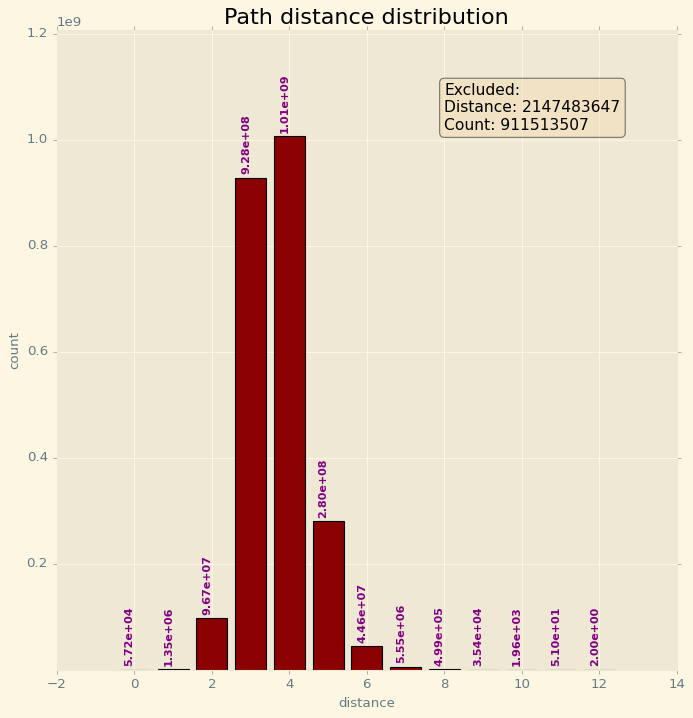

In [190]:
vals = list(hist_paths.values())[:1]
vals.extend(list(hist_paths.values())[2:])

plt.style.use('Solarize_Light2')

plt.figure(figsize=(10,10))
plt.bar(sorted(list(hist_paths.keys()))[:-1],vals,color = 'darkred')

plt.title('Path distance distribution',size=20)
plt.xlabel('distance')
plt.ylabel('count')
plt.ylim(min(vals),max(vals) * 1.2)
for i,v in enumerate(vals):
    if v > 1e4:
        n = str(np.around(v/1e9,4))
    else:
        n = str(v)
    plt.text(i-0.25,v+max(vals)/100, "{:.2e}".format(v),color = 'purple',fontweight='bold',size = 10,rotation=90)

textstr = '\n'.join((
    'Excluded:',
    f'Distance: {max(hist_paths.keys())}',
    f'Count: {hist_paths[max(hist_paths.keys())]}'
))

props = dict(boxstyle = 'round',facecolor='wheat', alpha =0.5)

plt.text(8, max(vals)*1.1, textstr,  fontsize=14,
        verticalalignment='top', bbox=props)
        
# plt.text(8,max(vals),f'Excluded distance: {max(hist_paths.keys())} \n having a count:    {hist_paths[max(hist_paths.keys())]}',size = 10,color = 'green',fontweight='bold')

plt.savefig('../images/path_distance_distribution_no_max.pdf')

the plot above kinda corroborates the negative assortativity coefficient I found before, as we don't have a long tail (i.e. higher distancees with lower counts), which is instead a sign of an assortative network.

# Community detection

In [8]:
'''
Nestest Stochastic block model
'''
%%time
state = gt.inference.minimize_blockmodel_dl(g)

In [407]:
gt.inference.minimize_blockmodel_df?

Object `gt.inference.minimize_blockmodel_df` not found.


In [17]:
state

<BlockState object with 57228 blocks (586 nonempty), degree-corrected, for graph <Graph object, directed, with 57228 vertices and 1354579 edges, at 0x7ff2a9540b50>, at 0x7ff2a95406d0>

In [14]:
b = state.get_blocks()

10031


In [31]:
len(set(list(b)))
print(f'You have {len(set(list(b)))} detected communities')

586

In [61]:
'''
Add the communities to the nodes dataset.
'''
# nodes['community'] = list(b)[:-1]
# nodes.to_csv('../data/nodes.csv',index=False)

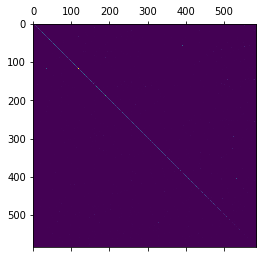

In [24]:
'''
Plot matrix of edge counts between groups
'''
b = gt.inference.contiguous_map(state.get_blocks())
state = state.copy(b=b)

e = state.get_matrix()

B = state.get_nonempty_B()
plt.matshow(e.todense()[:B, :B])
plt.savefig("../images/matrix_of_edge_counts.pdf")

'''
It's possible to see that groups are heavily separated (since the matrix is diagonal)
'''


In [25]:
bg = state.get_bg()
ers = state.mrs    # edge counts
nr = state.wr      # node counts

In [65]:
'''
Draw the graph communities (doesn't work, probably too many stuff to plot)
'''
# state.draw(output="NBS_full.pdf")

In [63]:
'''
What you could do is to plot the communities singularly
'''

'\nWhat you could do is to plot the communities singularly\n'

In [21]:
'''
Compute conductance of the different communities
'''
sorted([(np.sum(nodes.community == j),j) for j in range(586)])[::-1]

[(400, 263),
 (341, 115),
 (337, 119),
 (331, 13),
 (330, 30),
 (298, 173),
 (294, 240),
 (294, 209),
 (289, 235),
 (286, 189),
 (279, 379),
 (256, 10),
 (254, 24),
 (248, 56),
 (241, 246),
 (234, 367),
 (231, 49),
 (225, 147),
 (223, 21),
 (222, 59),
 (221, 166),
 (220, 170),
 (218, 53),
 (216, 243),
 (216, 200),
 (215, 149),
 (212, 27),
 (210, 345),
 (208, 65),
 (207, 126),
 (206, 68),
 (206, 0),
 (202, 136),
 (200, 86),
 (200, 43),
 (199, 229),
 (197, 197),
 (197, 50),
 (196, 139),
 (193, 169),
 (192, 392),
 (192, 46),
 (191, 286),
 (189, 390),
 (189, 329),
 (188, 427),
 (188, 264),
 (188, 198),
 (188, 179),
 (187, 327),
 (186, 406),
 (186, 165),
 (186, 75),
 (184, 203),
 (184, 159),
 (183, 168),
 (182, 91),
 (181, 118),
 (181, 83),
 (180, 398),
 (179, 106),
 (178, 441),
 (178, 282),
 (173, 287),
 (173, 247),
 (172, 230),
 (172, 172),
 (171, 475),
 (171, 206),
 (171, 138),
 (170, 227),
 (170, 217),
 (170, 157),
 (169, 360),
 (169, 312),
 (169, 199),
 (169, 176),
 (169, 131),
 (168, 

# Modularity approach for community detection

In [ ]:
'''
To do: 
1. Use consensus clustering with the louvain algorithm
    1. Apply louvain to g to yield P community partitions
    2. compute the consensus matrix D where:
        * D_ij is the fraction of partitions in which vertices i and j are assignet to the same cluster
        * entries below a chosen threshold are set to zero
    3. apply Louvain to D to yield P partitions:
        * if the partitions are all equal, stop
        * otherwise go back to 2
2. use the mutual information and 
'''

In [34]:
import community as community_louvain
community_louvain.best_partition(gnx)

AttributeError: module 'community' has no attribute 'best_partition'

In [35]:
community_louvain

<module 'community' from '/home/tron/.local/lib/python3.9/site-packages/community/__init__.py'>

## Inspect modularity classes from gephi

In [5]:
nodes_mod = pd.read_csv('../data/nodes_with_modularity.csv')
nodes_mod.head()

,Id,Label,timeset,category,community,Degree,modularity_class
0,1,cheese aging,NaN,['Howto & Style'],0,28,61
1,2,mumbai street food,NaN,['Travel & Events'],1,31,61
2,3,John Gallagher Jr.,NaN,['Film & Animation'],2,17,107
3,4,masks,NaN,"['People & Blogs', 'Education']",3,36,24
4,5,african american health,NaN,['News & Politics'],4,22,24


In [11]:
nodes_mod.groupby('modularity_class').count()

,Id,Label,timeset,category,community,Degree
modularity_class,,,,,,
0,558,558,0,558,558,558
1,1697,1697,0,1697,1697,1697
2,600,600,0,600,600,600
3,6,6,0,6,6,6
4,3477,3477,0,3477,3477,3477
...,...,...,...,...,...,...
139,4,4,0,4,4,4
140,11,11,0,11,11,11
141,3,3,0,3,3,3


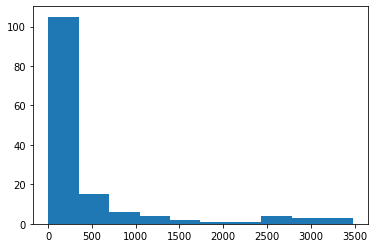

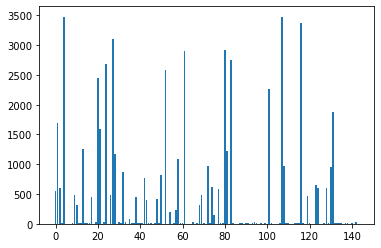

In [13]:
'''
Inspect communities distribution of # nodes
'''
plt.hist(nodes_mod.groupby('modularity_class').count().Id.values)
# plt.gca().set_xscale('log')
plt.show()

plt.bar(nodes_mod.groupby('modularity_class').count().index,nodes_mod.groupby('modularity_class').count().Id.values)
plt.show()

In [276]:

class TextHandler(HandlerBase):
    def create_artists(self, legend,tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]

Num. of classes: 144
0 0
0 1
1 0
1 1


<Figure size 1000x500 with 0 Axes>

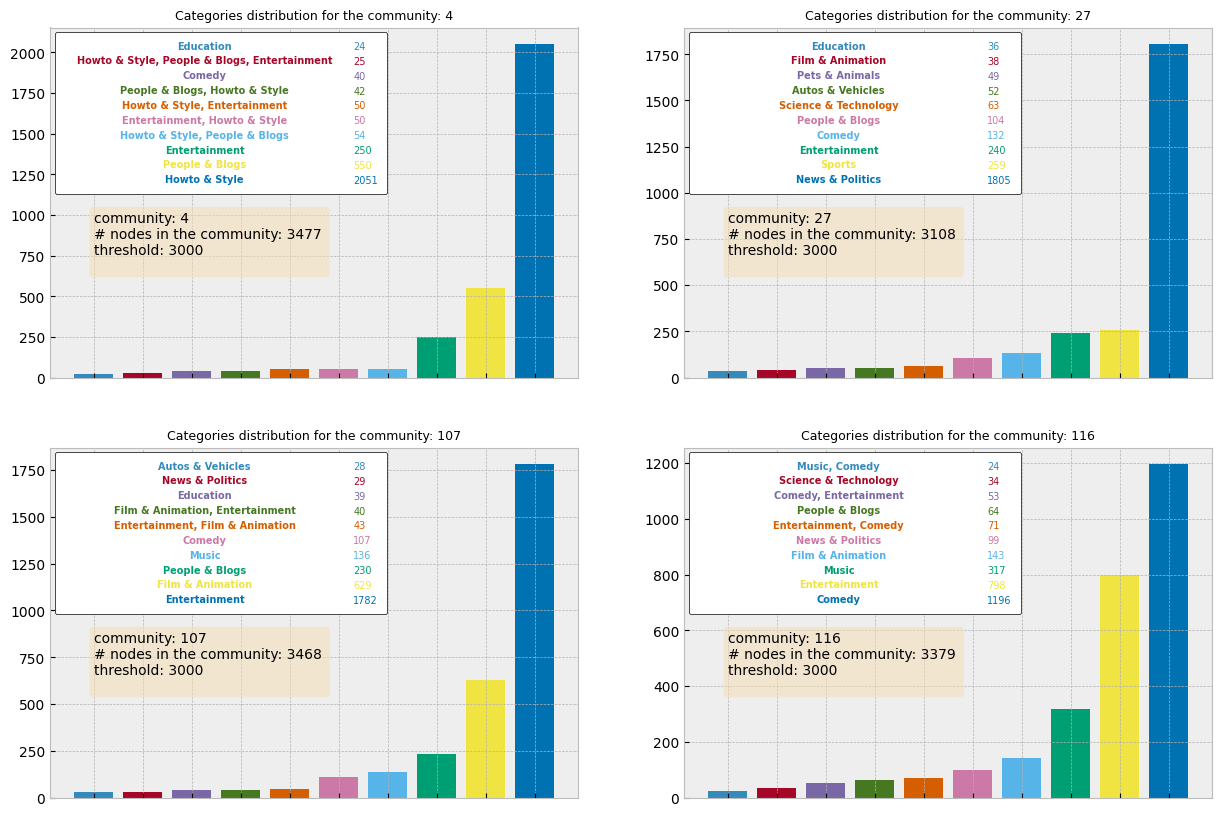

In [323]:
print(f'Num. of classes: {len(set(nodes_mod.modularity_class.values))}')
n_comms = 4
threshold = 3000

fig = plt.figure(figsize = (10,5))
plt.rcParams.update(plt.rcParamsDefault)

plt.style.use('bmh')


n_com = 1
rows = 2
cols = 2
row = 0
col = 0
fig, axs = plt.subplots(rows,cols,figsize=(15,10))

for com in range(len(set(nodes_mod.modularity_class.values))):
    if len(nodes_mod[nodes_mod.modularity_class == com]) > threshold:
        
        axs[row,col].bar(x =  nodes_mod[nodes_mod.modularity_class == com].groupby('category').count().sort_values(by=['Id']).iloc[-10:,:].index,height= nodes_mod[nodes_mod.modularity_class == com].groupby('category').count().sort_values(by=['Id']).iloc[-10:,:].Id.values, color = sns.color_palette(None, 10))#.plot.bar(y='Id',label='community counts',color = 'darkred'))
        # plt.xticks(nodes_mod[nodes_mod.modularity_class == 4].groupby('category').count().index.values)
        
        axs[row,col].set_title(f'Categories distribution for the community: {com}',fontsize=9)
        # plt.title(f'Distribution of category for community: {com}')
        # plt.xlabel('Categories')
        # plt.ylabel('Count')
        # axs[row,col].set_xticklabels(labels = None)
        # plt.xticks(rotation=90)
        axs[row,col].set(xticklabels=[])
        # axs[row,col].legend(nodes_mod[nodes_mod.modularity_class == com].groupby('category').count().sort_values(by=['Id']).iloc[-10:,:].index,['red' for _ in range(10)])
        cats = ''
        names = []
        for colr,cat in enumerate(nodes_mod[nodes_mod.modularity_class == com].groupby('category').count().sort_values(by=['Id']).iloc[-10:,:].index):
            to_replace = ['\'','\[','\]','\"']
            for replace in to_replace:
                cat = re.sub(replace,'',cat)
            names.append(cat)
            colr = sns.color_palette(None,10)[colr]
            colr = rgb2hex(int(colr[0]*255),int(colr[1]*255),int(colr[2]*255))
            cats += f'#0000FF: {cat} \n' 

        textstr = ''.join((
            f'community: {com} \n',
            f'# nodes in the community: {len(nodes_mod[nodes_mod.modularity_class == com])} \n'
            f'threshold: {threshold} \n'
        ))

        props = dict(boxstyle = 'round',facecolor='wheat', alpha =0.5)

        axs[row,col].text(0, nodes_mod[nodes_mod.modularity_class == com].groupby('category').count().sort_values(by=['Id']).iloc[-1,:].Id * (1 - 0.5), textstr,  fontsize=10,
                verticalalignment='top', bbox=props)
        
        # names = nodes_mod[nodes_mod.modularity_class == com].groupby('category').count().sort_values(by=['Id']).iloc[-10:,:].index

        handles = [(names[i],rgb2hex(int(colr[0]*255),int(colr[1]*255),int(colr[2]*255))) for i,colr in enumerate(list(sns.color_palette(None,10)))]
        # handles = [(i,'#000000') for i in range(10)]
        labels = [str(lab) for lab in nodes_mod[nodes_mod.modularity_class == com].groupby('category').count().sort_values(by=['Id']).iloc[-10:,:].Id.values]
        
        leg = axs[row,col].legend(handles=handles, labels=labels, handler_map={tuple : TextHandler()},
          facecolor='white', edgecolor='black', borderpad=0.9, framealpha=1, 
          fontsize=7, handlelength=29)

        for h, t in zip(leg.legendHandles, leg.get_texts()):
            t.set_color(h.get_color())
        
        
        
        if col == cols-1:
            col = 0
            if row < rows-1:
                row += 1
        elif col < cols-1:
            col += 1
        
        

plt.savefig('../images/modularity_top_4_comm.pdf')

# Visualise the graph

In [52]:
# g = load_graph("price.xml.gz")
# age = g.vertex_properties["age"]

pos = sfdp_layout(g)
graph_draw(g, pos, output_size=(1000, 1000), vertex_color=[1,1,1,0], 
           vertex_size=1, edge_pen_width=1.2,
           vcmap=matplotlib.cm.gist_heat_r, output="graph_full.pdf")

In [ ]:
# g_test = price_network(3000)
# pos = sfdp_layout(g_test)
graph_draw(g_test, pos=pos,output_size=(1000, 1000), vertex_color=[1,1,1,111], 
           vertex_size=1, edge_pen_width=1.2,output='graph_test.pdf')